In [1]:
import re
import time
import torch
import torchvision
import torchvision.transforms as transforms
from skimage.util import random_noise
import numpy as np
import random
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torch.distributions as dist

In [2]:
transform_train = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
transform_test = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False)
j = 1

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
def sample_lp_corr(noise_type, epsilon, img, density_distribution):
    d = len(img.ravel())
    if epsilon == 0:
        return img
    else:
        pixels = []
        if noise_type == 'uniform-linf':
            if density_distribution == 'max':  # sample on the hull of the norm ball
                rand = np.random.random(img.shape)
                sign = np.where(rand < 0.5, -1, 1)
                img = img + (sign * epsilon)
            else: #sample uniformly inside the norm ball
                img = dist.Uniform(img - epsilon, img + epsilon).sample()
            img = np.ma.clip(img, 0, 1) # clip values below 0 and over 1
        elif noise_type == 'uniform-linf-brightness': #only max-distribution, every pixel gets same manipulation
            img = random.choice([img - epsilon, img + epsilon])
            img = np.ma.clip(img, 0, 1) # clip values below 0 and over 1
        elif noise_type == 'gaussian': #note that this has no option for density_distribution=max
            var = epsilon * epsilon
            img = torch.tensor(random_noise(img, mode='gaussian', mean=0, var=var, clip=True))
        elif noise_type == 'uniform-l0-salt-pepper': #note that this has no option for density_distribution=max
            for j in range(round(epsilon * torch.numel(img[0]))):
                pixels.append(random.randint(0, torch.numel(img[0])))
            for pixel in pixels:
                max_pixel = random.choice([0, 1])
                img[0].view(-1)[pixel-1] = max_pixel
                img[1].view(-1)[pixel-1] = max_pixel
                img[2].view(-1)[pixel-1] = max_pixel
        elif noise_type == 'uniform-l0-impulse-max':
            for j in range(round(epsilon * torch.numel(img))):
                pixels.append(random.randint(0, torch.numel(img)))
            for pixel in pixels:
                img.view(-1)[pixel-1] = random.choice([0, 1])
        elif noise_type == 'uniform-l0-impulse-linear':
            for j in range(round(epsilon * torch.numel(img))):
                pixels.append(random.randint(0, torch.numel(img)))
            for pixel in pixels:
                img.view(-1)[pixel-1] = random.randint(0, 255) / 255
        elif 'uniform-l' in noise_type: 
            lp = [float(x) for x in re.findall(r'-?\d+\.?\d*', noise_type)]
            lp = lp[0]
            u = np.random.laplace(0, 1 / lp, size=(np.array(img).shape))  
            norm = np.sum(abs(u) ** lp) ** (1 / lp)
            if density_distribution == 'max':
                r = 1 
            else:
                r = np.random.random() ** (1.0 / d)
            corr = epsilon * r * u / norm
            img = img + corr
            img = np.ma.clip(img, 0, 1)
        else:
            print('Unknown type of noise')
            
    return img

def check_lp_corr(noise_type, epsilon, img, corr_img):
    checker = False
    diff = np.empty(img.shape)
    d = len(img.ravel())
    if noise_type == 'uniform-linf':
        diff = np.absolute(img - corr_img)
        diff = np.asarray(diff)
        if diff.max() > epsilon:
            checker = False
        else:
            checker = True      
    elif noise_type == 'uniform-l0-salt-pepper': #note that this has no option for density_distribution=max
        diff = img - corr_img
        diff = np.asarray(diff)
        if np.count_nonzero(diff) > (epsilon * d):
            checker = False
        else:
            checker = True
    elif noise_type == 'uniform-l0-impulse-max':
        diff = img - corr_img
        diff = np.asarray(diff)
        if np.count_nonzero(diff) > (epsilon * d):
            checker = False
        else:
            checker = True
    elif noise_type == 'uniform-l0-impulse-linear':
        diff = img - corr_img
        diff = np.asarray(diff)
        if np.count_nonzero(diff) > (epsilon * d):
            checker = False
        else:
            checker = True
    elif 'uniform-l' in noise_type: 
        lp = [float(x) for x in re.findall(r'-?\d+\.?\d*', noise_type)]  # extract Lp-number from args.noise variable
        lp = lp[0]
        diff = np.absolute(img - corr_img)
        diff = np.asarray(diff)
        dist = np.sum(diff ** lp) ** (1 / lp)
        if dist > epsilon:
            checker = False
        else:
            checker = True
    else:
        print('Unknown type of noise')
    return checker

def compare_sample_volumes(samples, noise_type1, epsilon1, noise_type2, epsilon2):
    transform_train = transforms.Compose([
        transforms.ToTensor()
        ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False)
    j = 1
    counter = 0
    
    for id, (input, target) in enumerate(trainloader):
        if j == id:
            image = input
            break
    image = torch.squeeze(image)
    
    for f in range(samples):
        corrupted_image = sample_lp_corr(noise_type1, epsilon1, image, 'notmax')
        for id, (input, target) in enumerate(trainloader):
            if j == id:
                image = input
                break
        image = torch.squeeze(image)
        checked = check_lp_corr(noise_type2, epsilon2, image, corrupted_image)
        if checked == True:
            counter = counter + 1
    return counter

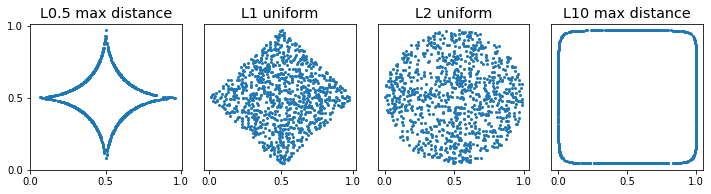

In [4]:
#plot a 2D scatterplot of n samples of points from various Lp-norms to visualize their 2d distribution
point = np.array([0.5, 0.5])
n = 1000
samples1 = np.empty([n, 2])
samples2 = np.empty([n, 2])
samples3 = np.empty([n, 2])
samples4 = np.empty([n, 2])
for i in range(n):
    samples1[i,:] = sample_lp_corr('uniform-l0.5', 0.5, point, 'max')
    samples2[i,:] = sample_lp_corr('uniform-l1', 0.5, point, 'nope')
    samples3[i,:] = sample_lp_corr('uniform-l2', 0.5, point, 'nope')
    samples4[i,:] = sample_lp_corr('uniform-l10', 0.5, point, 'max')

fig, axs = plt.subplots(figsize=(10, 2.8), sharey='row', sharex=True)

axes1 = plt.subplot(141)
axes2 = plt.subplot(142)
axes3 = plt.subplot(143)
axes4 = plt.subplot(144)
axes1.scatter(samples1[:,0], samples1[:,1], s=4)
axes2.scatter(samples2[:,0], samples2[:,1], s=4)
axes3.scatter(samples3[:,0], samples3[:,1], s=4)
axes4.scatter(samples4[:,0], samples4[:,1], s=4)
axes1.set_xticks([0, 0.5, 1])
axes2.set_xticks([0, 0.5, 1])
axes3.set_xticks([0, 0.5, 1])
axes4.set_xticks([0, 0.5, 1])
axes1.set_yticks([0, 0.5, 1])
axes2.set_yticks([])
axes3.set_yticks([])
axes4.set_yticks([])
axes1.set_title('L0.5 max distance', size='x-large')
axes2.set_title('L1 uniform', size='x-large')
axes3.set_title('L2 uniform', size='x-large')
axes4.set_title('L10 max distance', size='x-large')
plt.tight_layout()
plt.savefig('Lp-norms-2D.pdf')

In [5]:
samples = 1000
count = compare_sample_volumes(samples, 'uniform-l2', 0.5, 'uniform-linf', 0.1)
print(count, "of", samples, "samples of the two noise types are in the same volume")

# l1 25 prety much entirely completely covers l0.5 50000, l2 0.5, l10 0.06, l50 0.05, linf 0.01

Files already downloaded and verified
1000 of 1000 samples of the two noise types are in the same volume


In [6]:
samples = 1000
l0l2 = np.empty([2, 8])
l0l2[0, :] = np.array([0, 0.01, 0.012, 0.015, 0.0175, 0.02, 0.024, 0.1])
l2l0 = np.empty([2, 3])
l2l0[0, :] = np.array([0.9, 0.999, 1.0])
l1l2 = np.empty([2, 8])
l0_5l2 = np.empty([2, 13])
l0_5l2[0, :] = np.array([0.0, 300000, 360000, 370000, 380000, 385000, 387500, 390000, 392500, 395000, 400000, 410000, 450000])
l2l0_5 = np.empty([2, 12])
l2l0_5[0, :] = np.array([0.0, 300000, 360000, 365000, 370000, 372500, 375000, 380000, 385000, 390000, 410000, 450000])
l1l2 = np.empty([2, 12])
l1l2[0, :] = np.array([0.0, 100, 140, 150, 156, 158, 160, 162, 164, 166, 170, 180])
l2l1 = np.empty([2, 12])
l2l1[0, :] = np.array([0.0, 100, 140, 148, 150, 152, 154, 156, 158, 160, 170, 180])
l10l2 = np.empty([2, 12])
l10l2[0, :] = np.array([0.0, 0.3, 0.4, 0.425, 0.45, 0.475, 0.5, 0.55, 0.6, 0.7, 0.8, 1.0])
l2l10 = np.empty([2, 12])
l2l10[0, :] = np.array([0.0, 0.3, 0.4, 0.425, 0.45, 0.475, 0.5, 0.55, 0.6, 0.7, 0.8, 1.0])
l50l2 = np.empty([2, 13])
l50l2[0, :] = np.array([0.0, 0.3, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.55, 0.6, 0.7, 1.0])
l2l50 = np.empty([2, 13])
l2l50[0, :] = np.array([0.0, 0.3, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5, 0.55, 0.6, 0.7, 1.0])
linfl2 = np.empty([2, 9])
linfl2[0, :] = np.array([0.0, 0.12, 0.125, 0.126, 0.127, 0.128, 0.129, 0.14, 0.2])
l2linf = np.empty([2, 11])
l2linf[0, :] = np.array([0.3, 0.325, 0.35, 0.375, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 1.0])
for id, eps in enumerate(l0l2[0, :]):
    l0l2[1, id] = compare_sample_volumes(samples, 'uniform-l0-impulse-max', eps, 'uniform-l2', 4)
print(l0l2)
for id, eps in enumerate(l2l0[0, :]):
    l2l0[1, id] = compare_sample_volumes(samples, 'uniform-l2', 4, 'uniform-l0-impulse-max', eps)
print(l2l0)
for id, eps in enumerate(l0_5l2[0, :]):
    l0_5l2[1, id] = compare_sample_volumes(samples, 'uniform-l0.5', eps, 'uniform-l2', 4)
print(l0_5l2)
for id, eps in enumerate(l2l0_5[0, :]):
    l2l0_5[1, id] = compare_sample_volumes(samples, 'uniform-l2', 4, 'uniform-l0.5', eps)
print(l2l0_5)
for id, eps in enumerate(l1l2[0, :]):
    l1l2[1, id] = compare_sample_volumes(samples, 'uniform-l1', eps, 'uniform-l2', 4)
print(l1l2)
for id, eps in enumerate(l2l1[0, :]):
    l2l1[1, id] = compare_sample_volumes(samples, 'uniform-l2', 4, 'uniform-l1', eps)
print(l2l1)
for id, eps in enumerate(l10l2[0, :]):
    l10l2[1, id] = compare_sample_volumes(samples, 'uniform-l10', eps, 'uniform-l2', 4)
print(l10l2)
for id, eps in enumerate(l2l10[0, :]):
    l2l10[1, id] = compare_sample_volumes(samples, 'uniform-l2', 4, 'uniform-l10', eps)
print(l2l10)
for id, eps in enumerate(l50l2[0, :]):
    l50l2[1, id] = compare_sample_volumes(samples, 'uniform-l50', eps, 'uniform-l2', 4)
print(l50l2)
for id, eps in enumerate(l2l50[0, :]):
    l2l50[1, id] = compare_sample_volumes(samples, 'uniform-l2', 4, 'uniform-l50', eps)
print(l2l50)
for id, eps in enumerate(linfl2[0, :]):
    linfl2[1, id] = compare_sample_volumes(samples, 'uniform-linf', eps, 'uniform-l2', 4)
print(linfl2)
for id, eps in enumerate(l2linf[0, :]):
    l2linf[1, id] = compare_sample_volumes(samples, 'uniform-l2', 4, 'uniform-linf', eps)
print(l2linf)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[[0.00e+00 1.00e-02 1.20e-02 1.50e-02 1.75e-02 2.00e-02 2.40e-02 1.00e-01]
 [1.00e+03 1.00e+03 9.99e+02 8.80e+02 4.30e+02 1.03e+02 0.00e+00 0.00e+00]]
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[[9.00e-01 9.99e-01 1.00e+00]
 [0.00e+00 0.00e+00 1.00e+03]]
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and

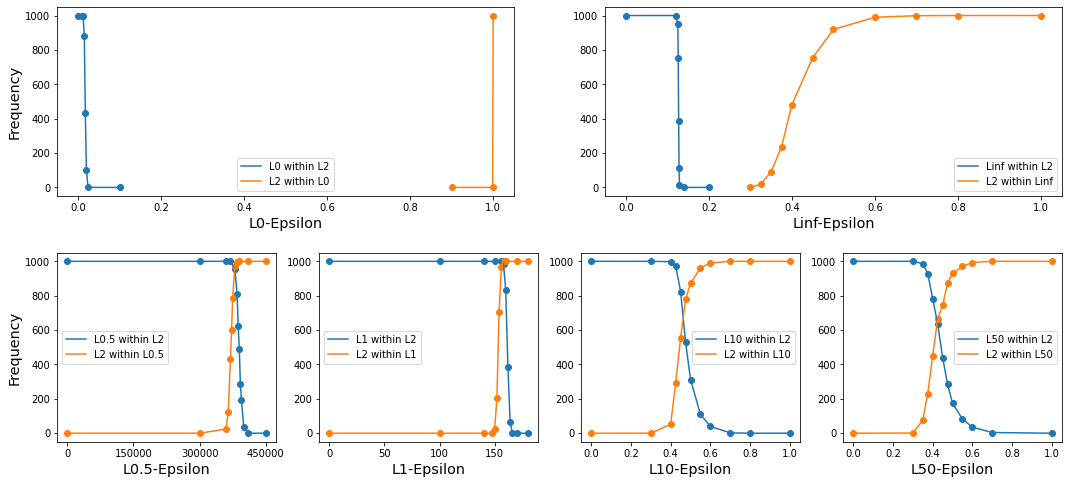

In [7]:
import matplotlib.pyplot as plt
x1 = l0l2[0,:]
y1 = l0l2[1,:]
x2 = l2l0[0,:]
y2 = l2l0[1,:]
x3 = l0_5l2[0,:]
y3 = l0_5l2[1,:]
x4 = l2l0_5[0,:]
y4 = l2l0_5[1,:]
x5 = l1l2[0,:]
y5 = l1l2[1,:]
x6 = l2l1[0,:]
y6 = l2l1[1,:]
x7 = l10l2[0,:]
y7 = l10l2[1,:]
x8 = l2l10[0,:]
y8 = l2l10[1,:]
x9 = l50l2[0,:]
y9 = l50l2[1,:]
x10 = l2l50[0,:]
y10 = l2l50[1,:]
x11 = linfl2[0,:]
y11 = linfl2[1,:]
x12 = l2linf[0,:]
y12 = l2linf[1,:]
fig1, axs = plt.subplots(figsize=(18, 8), sharey='row')
axes1 = plt.subplot(221)
axes2 = plt.subplot(245)
axes3 = plt.subplot(246)
axes4 = plt.subplot(247)
axes5 = plt.subplot(248)
axes6 = plt.subplot(222)
plt.subplots_adjust(hspace=0.3)
axes1.scatter(x1, y1)
axes1.plot(x1, y1, label='L0 within L2')
axes1.scatter(x2, y2)
axes1.plot(x2, y2, label='L2 within L0')
axes2.scatter(x3, y3)
axes2.plot(x3, y3, label='L0.5 within L2')
axes2.scatter(x4, y4)
axes2.plot(x4, y4, label='L2 within L0.5')
axes3.scatter(x5, y5)
axes3.plot(x5, y5, label='L1 within L2')
axes3.scatter(x6, y6)
axes3.plot(x6, y6, label='L2 within L1')
axes4.scatter(x7, y7)
axes4.plot(x7, y7, label='L10 within L2')
axes4.scatter(x8, y8)
axes4.plot(x8, y8, label='L2 within L10')
axes5.scatter(x9, y9)
axes5.plot(x9, y9, label='L50 within L2')
axes5.scatter(x10, y10)
axes5.plot(x10, y10, label='L2 within L50')
axes6.scatter(x11, y11)
axes6.plot(x11, y11, label='Linf within L2')
axes6.scatter(x12, y12)
axes6.plot(x12, y12, label='L2 within Linf')
axes1.set_ylabel('Frequency', fontsize= 'x-large')
axes2.set_ylabel('Frequency', fontsize= 'x-large')
axes1.set_xlabel('L0-Epsilon', fontsize= 'x-large')
axes2.set_xlabel('L0.5-Epsilon', fontsize= 'x-large')
axes2.set_xticks([0, 150000, 300000, 450000])
axes3.set_xlabel('L1-Epsilon', fontsize= 'x-large')
axes4.set_xlabel('L10-Epsilon', fontsize= 'x-large')
axes5.set_xlabel('L50-Epsilon', fontsize= 'x-large')
axes6.set_xlabel('Linf-Epsilon', fontsize= 'x-large')
#axes1.set_title('L0 Impulse', fontsize= 'x-large')
#axes2.set_title('L0.5', fontsize= 'x-large')
#axes3.set_title('L1', fontsize= 'x-large')
#axes4.set_title('L10', fontsize= 'x-large')
#axes5.set_title('L50', fontsize= 'x-large')
#axes6.set_title('Linf', fontsize= 'x-large')
#fig1.suptitle('Comparison of volumes of different CIFAR-10-dimensional norm balls with L2 (epsilon = 4) norm ball through sampling of 10.000 samples', fontsize=16)
axes1.legend()
axes2.legend()
axes3.legend()
axes4.legend()
axes5.legend()
axes6.legend()
plt.savefig('compare_volumes.pdf')

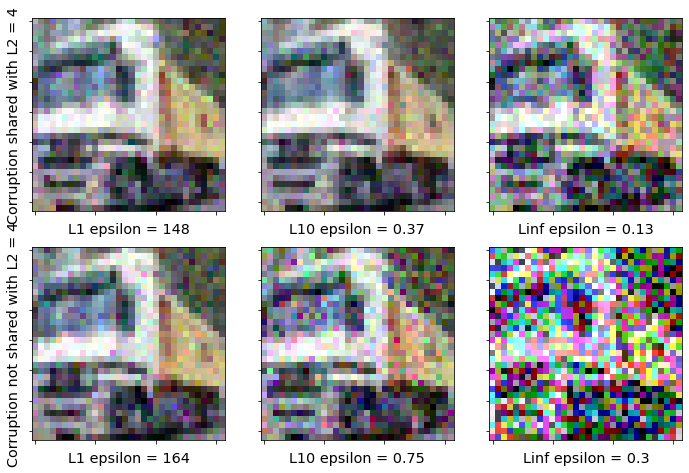

In [8]:
fig2, axs = plt.subplots(2, 3)
fig2.set_size_inches(10, 6.5)
for id, (input, target) in enumerate(trainloader):
    if j == id:
        image1 = input
        break
image1 = torch.squeeze(image1)
image1 = sample_lp_corr('uniform-l0-impulse-max', 0.03, image1, 'max')
image1 = image1.permute(1, 2, 0)
for id, (input, target) in enumerate(trainloader):
    if j == id:
        image2 = input
        break
image2 = torch.squeeze(image2)
image2 = sample_lp_corr('uniform-l0-impulse-max', 1, image2, 'max')
image2 = image2.permute(1, 2, 0)
for id, (input, target) in enumerate(trainloader):
    if j == id:
        image3 = input
        image4 = input
        break
image3 = torch.squeeze(image3)
image4 = torch.squeeze(image4)
image3 = sample_lp_corr('uniform-l1', 148, image3, 'max')
image4 = sample_lp_corr('uniform-l1', 164, image4, 'max')
image3 = image3.permute(1, 2, 0)
image4 = image4.permute(1, 2, 0)
for id, (input, target) in enumerate(trainloader):
    if j == id:
        image5 = input
        image6 = input
        break
image5 = torch.squeeze(image5)
image6 = torch.squeeze(image6)
image5 = sample_lp_corr('uniform-linf', 0.13, image5, 'max')
image6 = sample_lp_corr('uniform-linf', 0.3, image6, 'max')
image5 = image5.permute(1, 2, 0)
image6 = image6.permute(1, 2, 0)
for id, (input, target) in enumerate(trainloader):
    if j == id:
        image9 = input
        image10 = input
        break
image9 = torch.squeeze(image9)
image10 = torch.squeeze(image10)
image9 = sample_lp_corr('uniform-l10', 0.37, image9, 'max')
image10 = sample_lp_corr('uniform-l10', 0.75, image10, 'max')
image9 = image9.permute(1, 2, 0)
image10 = image10.permute(1, 2, 0)

axs[0, 0].imshow(image3)
axs[1, 0].imshow(image4)
axs[0, 1].imshow(image9)
axs[1, 1].imshow(image10)
axs[0, 2].imshow(image5)
axs[1, 2].imshow(image6)
axs[0, 0].set_ylabel('Corruption shared with L2 = 4', fontsize= 'x-large')
axs[1, 0].set_ylabel('Corruption not shared with L2 = 4', fontsize= 'x-large')
axs[0, 0].xaxis.set_ticklabels([])
axs[0, 0].yaxis.set_ticklabels([])
axs[0, 1].xaxis.set_ticklabels([])
axs[0, 1].yaxis.set_ticklabels([])
axs[0, 2].xaxis.set_ticklabels([])
axs[0, 2].yaxis.set_ticklabels([])
axs[1, 0].xaxis.set_ticklabels([])
axs[1, 0].yaxis.set_ticklabels([])
axs[1, 1].xaxis.set_ticklabels([])
axs[1, 1].yaxis.set_ticklabels([])
axs[1, 2].xaxis.set_ticklabels([])
axs[1, 2].yaxis.set_ticklabels([])
axs[0, 0].set_xlabel('L1 epsilon = 148', fontsize= 'x-large')
axs[1, 0].set_xlabel('L1 epsilon = 164', fontsize= 'x-large')
axs[0, 1].set_xlabel('L10 epsilon = 0.37', fontsize= 'x-large')
axs[1, 1].set_xlabel('L10 epsilon = 0.75', fontsize= 'x-large')
axs[0, 2].set_xlabel('Linf epsilon = 0.13', fontsize= 'x-large')
axs[1, 2].set_xlabel('Linf epsilon = 0.3', fontsize= 'x-large')
plt.tight_layout()
fig2.savefig("images_compared.pdf")

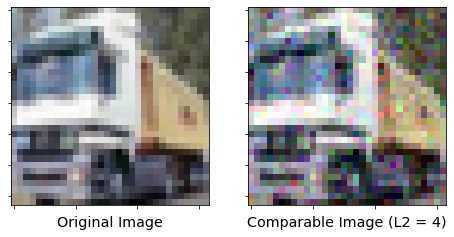

In [9]:
fig3, axs = plt.subplots(1, 2)
fig3.set_size_inches(7.8, 3.9)
for id, (input, target) in enumerate(trainloader):
    if j == id:
        image7 = input
        image8 = input
        break
image7 = torch.squeeze(image7)
image8 = torch.squeeze(image8)
image8 = sample_lp_corr('uniform-l2', 4, image8, 'max')
image7 = image7.permute(1, 2, 0)
image8 = image8.permute(1, 2, 0)
axs[0].imshow(image7)
axs[1].imshow(image8)
axs[0].xaxis.set_ticklabels([])
axs[0].yaxis.set_ticklabels([])
axs[1].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticklabels([])
axs[0].set_xlabel('Original Image', fontsize= 'x-large')
axs[1].set_xlabel('Comparable Image (L2 = 4)', fontsize= 'x-large')

fig3.savefig("images_basics.pdf")

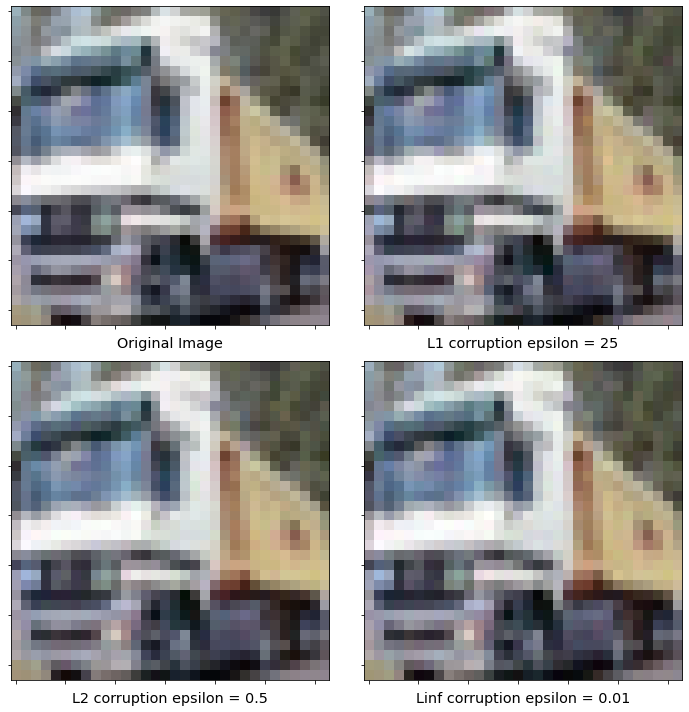

In [10]:
j=1
for id, (input, target) in enumerate(trainloader):
    if j == id:
        image9 = input
        image10 = input
        image11 = input
        image12 = input
        break
image9 = torch.squeeze(image9)
image10 = torch.squeeze(image10)
image11 = torch.squeeze(image11)
image12 = torch.squeeze(image12)
image10 = sample_lp_corr('uniform-l1', 20.0, image10, 'max')
image11 = sample_lp_corr('uniform-l2', 0.5, image11, 'max')
image12 = sample_lp_corr('uniform-linf', 0.01, image12, 'max')
image9 = image9.permute(1, 2, 0)
image10 = image10.permute(1, 2, 0)
image11 = image11.permute(1, 2, 0)
image12 = image12.permute(1, 2, 0)
fig4, axs = plt.subplots(2, 2)
fig4.set_size_inches(10, 10)
axs[0, 0].imshow(image9)
axs[0, 1].imshow(image10)
axs[1, 0].imshow(image11)
axs[1, 1].imshow(image12)
axs[0, 0].xaxis.set_ticklabels([])
axs[0, 0].yaxis.set_ticklabels([])
axs[0, 1].xaxis.set_ticklabels([])
axs[0, 1].yaxis.set_ticklabels([])
axs[1, 0].xaxis.set_ticklabels([])
axs[1, 0].yaxis.set_ticklabels([])
axs[1, 1].xaxis.set_ticklabels([])
axs[1, 1].yaxis.set_ticklabels([])
axs[0, 0].set_xlabel('Original Image', fontsize= 'x-large')
axs[0, 1].set_xlabel('L1 corruption epsilon = 25', fontsize= 'x-large')
axs[1, 0].set_xlabel('L2 corruption epsilon = 0.5', fontsize= 'x-large')
axs[1, 1].set_xlabel('Linf corruption epsilon = 0.01', fontsize= 'x-large')
plt.tight_layout()
fig4.savefig("imperceptible_corruptions_square.pdf")

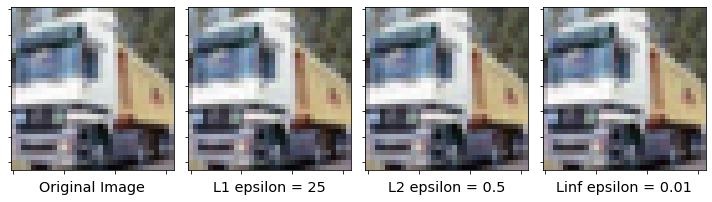

In [11]:
j=1
for id, (input, target) in enumerate(trainloader):
    if j == id:
        image9 = input
        image10 = input
        image11 = input
        image12 = input
        break
image9 = torch.squeeze(image9)
image10 = torch.squeeze(image10)
image11 = torch.squeeze(image11)
image12 = torch.squeeze(image12)
image10 = sample_lp_corr('uniform-l1', 20.0, image10, 'max')
image11 = sample_lp_corr('uniform-l2', 0.5, image11, 'max')
image12 = sample_lp_corr('uniform-linf', 0.01, image12, 'max')
image9 = image9.permute(1, 2, 0)
image10 = image10.permute(1, 2, 0)
image11 = image11.permute(1, 2, 0)
image12 = image12.permute(1, 2, 0)
fig4, axs = plt.subplots(1, 4)
fig4.set_size_inches(10, 10)
axs[0].imshow(image9)
axs[1].imshow(image10)
axs[2].imshow(image11)
axs[3].imshow(image12)
axs[0].xaxis.set_ticklabels([])
axs[0].yaxis.set_ticklabels([])
axs[1].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticklabels([])
axs[2].xaxis.set_ticklabels([])
axs[2].yaxis.set_ticklabels([])
axs[3].xaxis.set_ticklabels([])
axs[3].yaxis.set_ticklabels([])
axs[0].set_xlabel('Original Image', fontsize= 'x-large')
axs[1].set_xlabel('L1 epsilon = 25', fontsize= 'x-large')
axs[2].set_xlabel('L2 epsilon = 0.5', fontsize= 'x-large')
axs[3].set_xlabel('Linf epsilon = 0.01', fontsize= 'x-large')
plt.tight_layout()
fig4.savefig("imperceptible_corruptions_row.pdf")

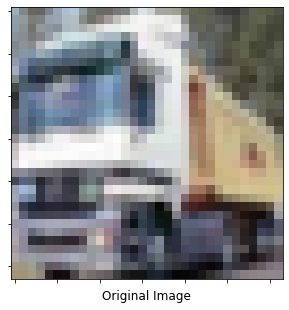

In [12]:
fig5, axs = plt.subplots(1)
fig5.set_size_inches(5, 5)
axs.imshow(image9)
axs.xaxis.set_ticklabels([])
axs.yaxis.set_ticklabels([])
axs.set_xlabel('Original Image', fontsize= 'large')

fig5.savefig("original_image.pdf")